In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scr
import pandas as pd
import scrublet as crub


sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


# P28_dl

## Read in data, basic pre-processing

In [3]:
base_path = '/Volumes/GoogleDrive/My Drive/mouse visual cortex/'

oneA = sc.read_10x_mtx(base_path + 'P28_dl_1_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
oneB = sc.read_10x_mtx(base_path + 'P28_dl_1_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
twoA = sc.read_10x_mtx(base_path + 'P28_dl_2_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
twoB = sc.read_10x_mtx(base_path + 'P28_dl_2_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [4]:
P28_dl = oneA.concatenate(oneB, twoA, twoB, batch_categories=['P28_dl_1a', 'P28_dl_1b', 'P28_dl_2a', 'P28_dl_2b'])

In [5]:
P28_dl

AnnData object with n_obs × n_vars = 31815 × 53801
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [6]:
sc.pp.filter_cells(P28_dl, min_genes=700) #cell must have 700 non-zero-count features to stay
sc.pp.filter_genes(P28_dl, min_cells=8) #gene must be in 8 cells to stay

filtered out 1467 cells that have less than 700 genes expressed
filtered out 28111 genes that are detected in less than 8 cells


In [7]:
P28_dl

AnnData object with n_obs × n_vars = 30348 × 25690
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [8]:
mito_genes = P28_dl.var_names.str.startswith('mt-') #boolean array denoting if a gene is mito

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

# add each cell's fraction mito accounts as an obs annotation
P28_dl.obs['percent_mito'] = np.sum(P28_dl[:, mito_genes].X, axis=1).A1 / np.sum(P28_dl.X, axis=1).A1

# add the total counts per cell as observations-annotation to P28_dl
P28_dl.obs['n_counts'] = P28_dl.X.sum(axis=1).A1

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7

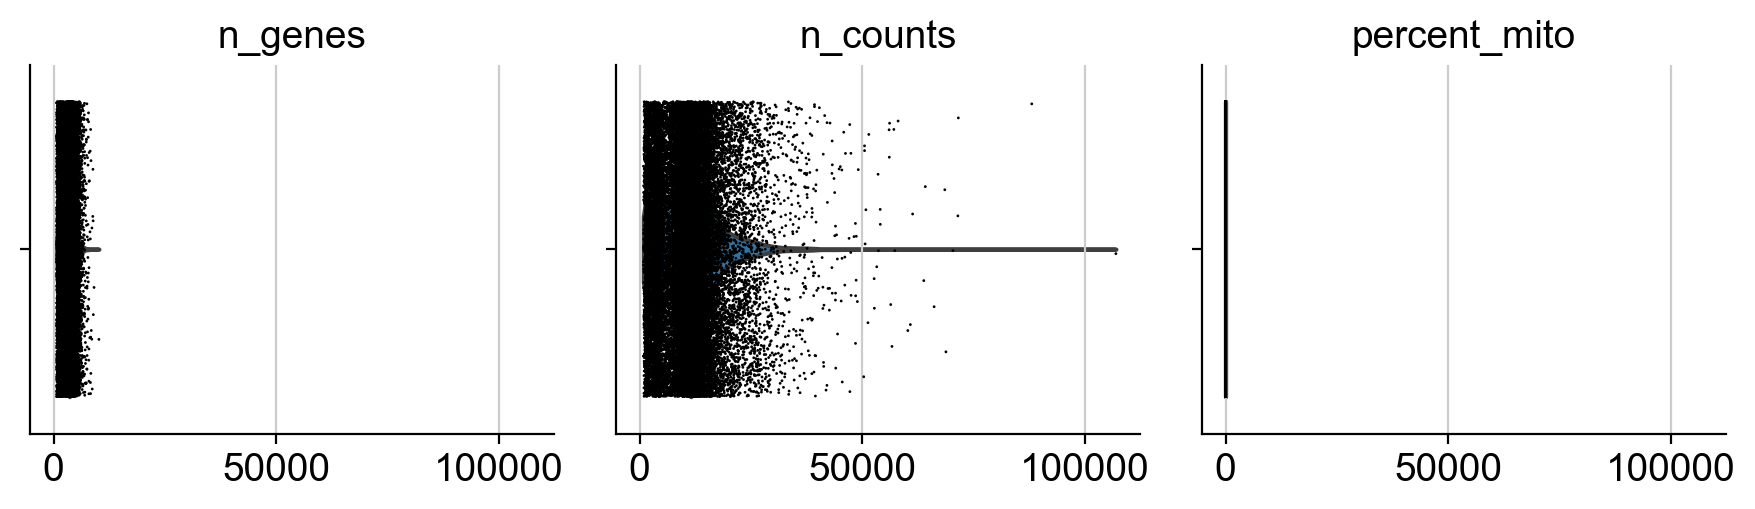

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


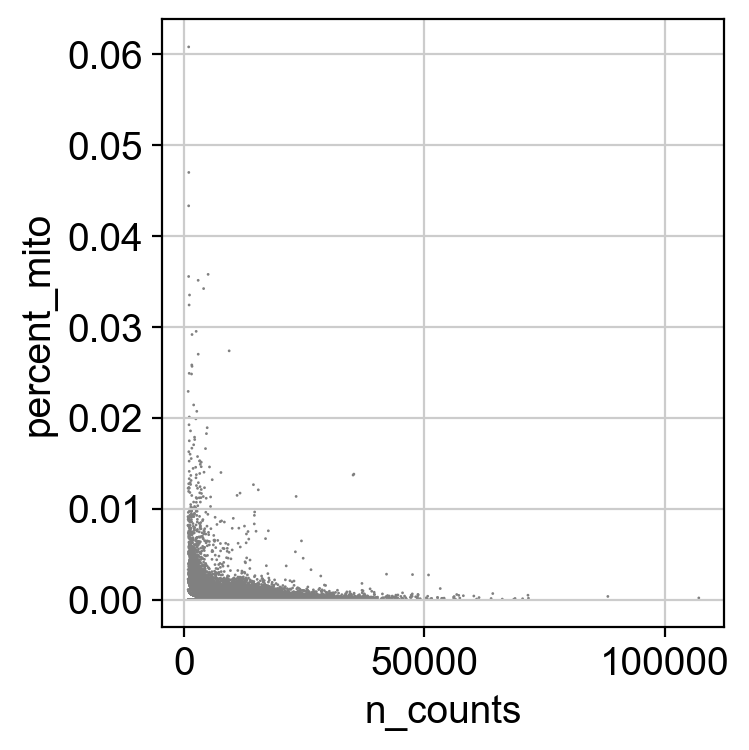

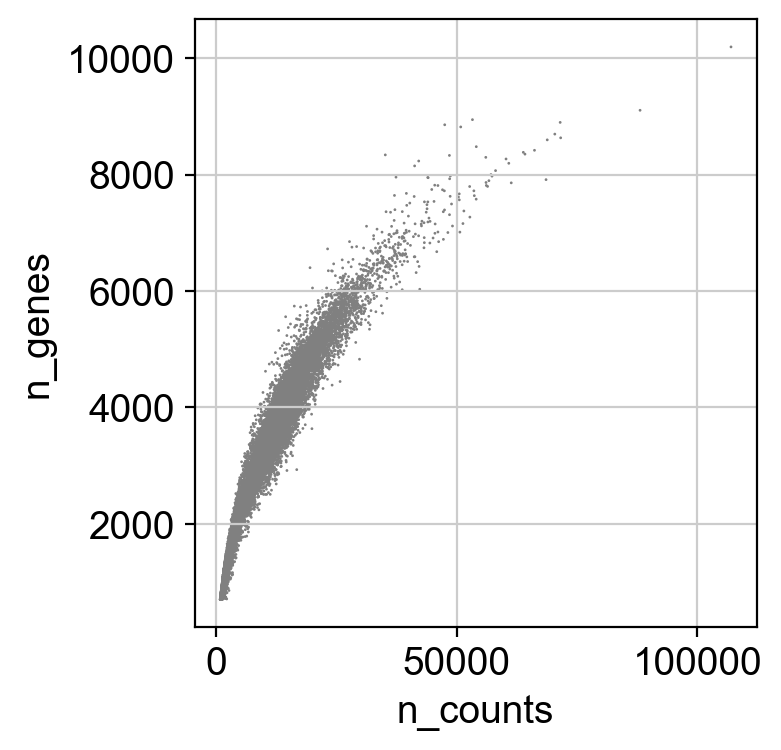

In [9]:
sc.pl.violin(P28_dl, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(P28_dl, x='n_counts', y='percent_mito')
sc.pl.scatter(P28_dl, x='n_counts', y='n_genes')

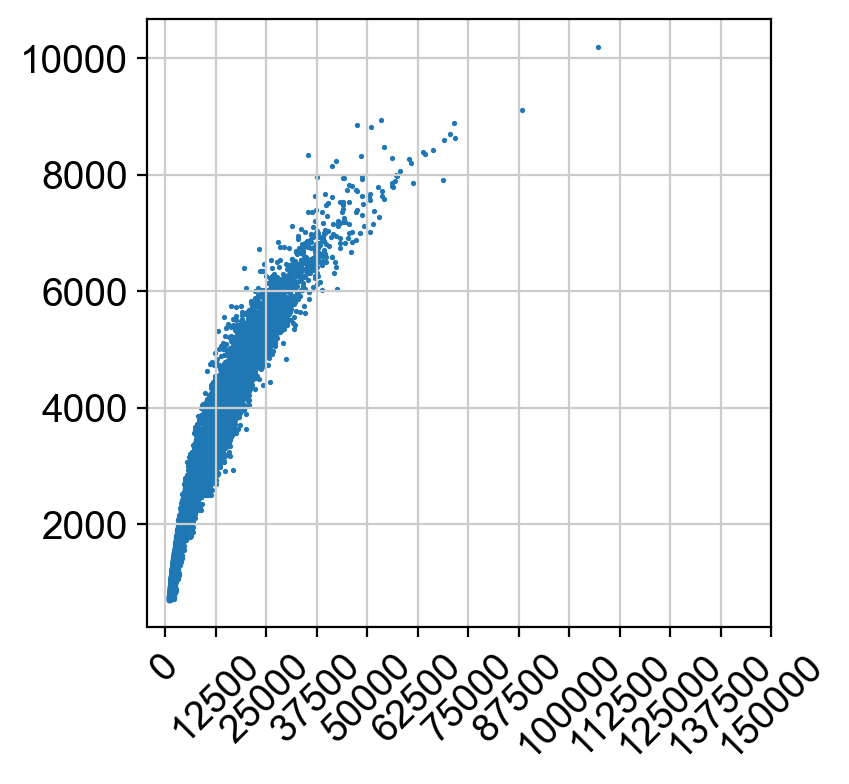

In [10]:
plt.scatter(P28_dl.obs['n_counts'], P28_dl.obs['n_genes'], s=0.8)
plt.xticks(np.linspace(0,150000, 13), rotation='45')
plt.show()

In [11]:
P28_dl = P28_dl[P28_dl.obs.percent_mito < 0.01, :]
P28_dl = P28_dl[P28_dl.obs['n_genes'] < 8000, :]
P28_dl = P28_dl[P28_dl.obs['n_counts'] < 40000, :]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [12]:
P28_dl

View of AnnData object with n_obs × n_vars = 30156 × 25690
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1319: UserW

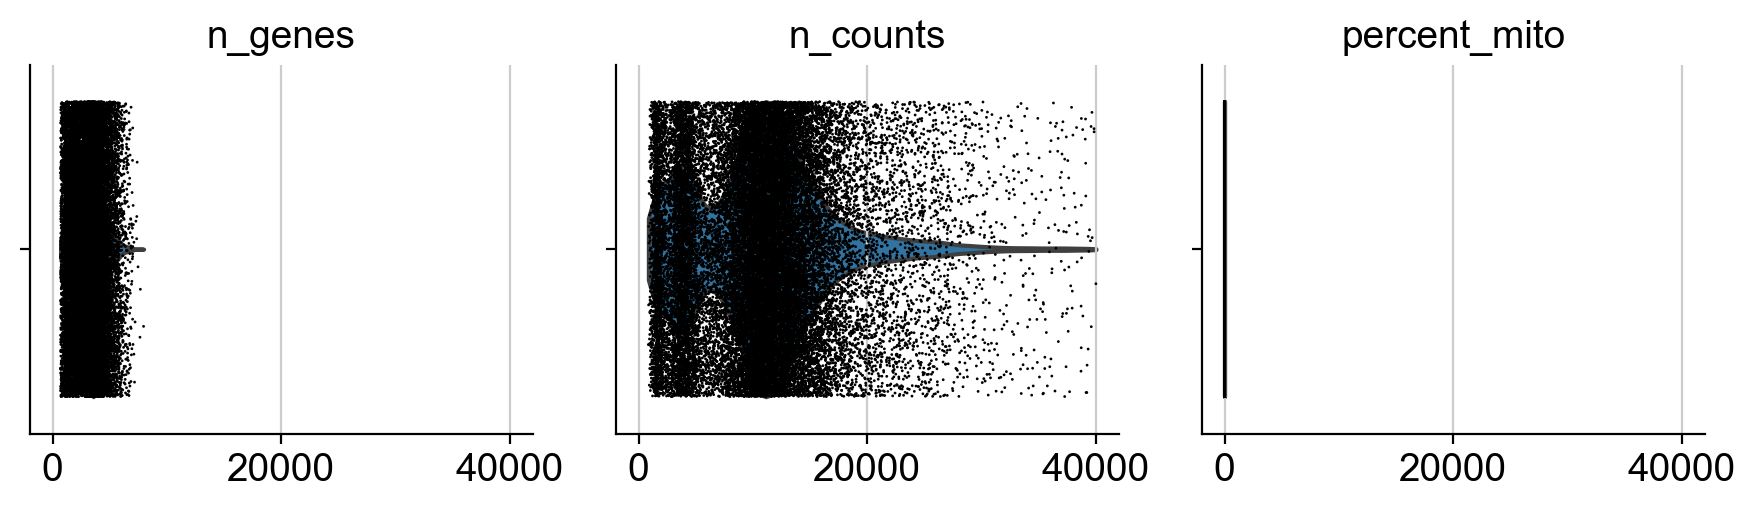

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


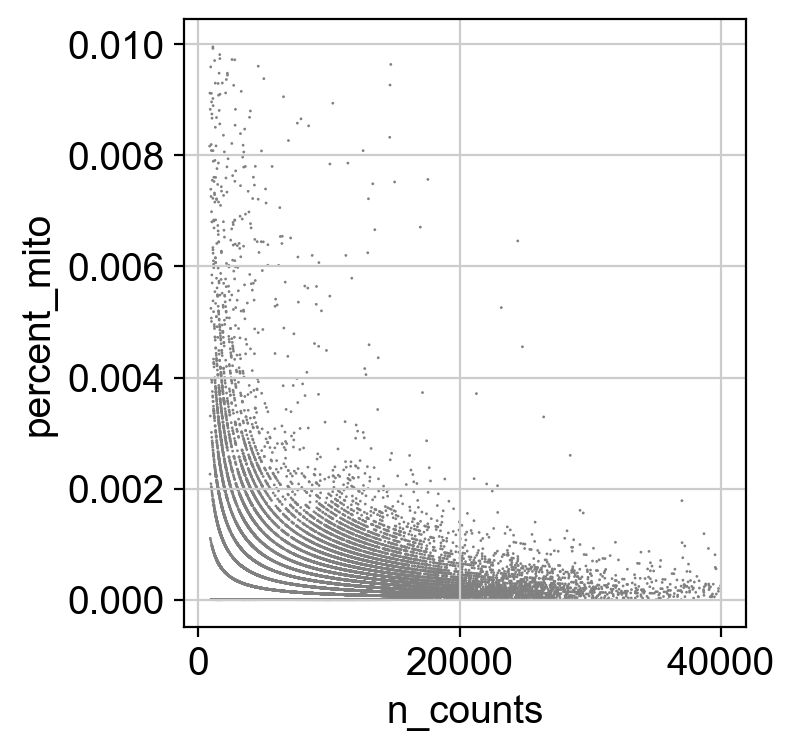

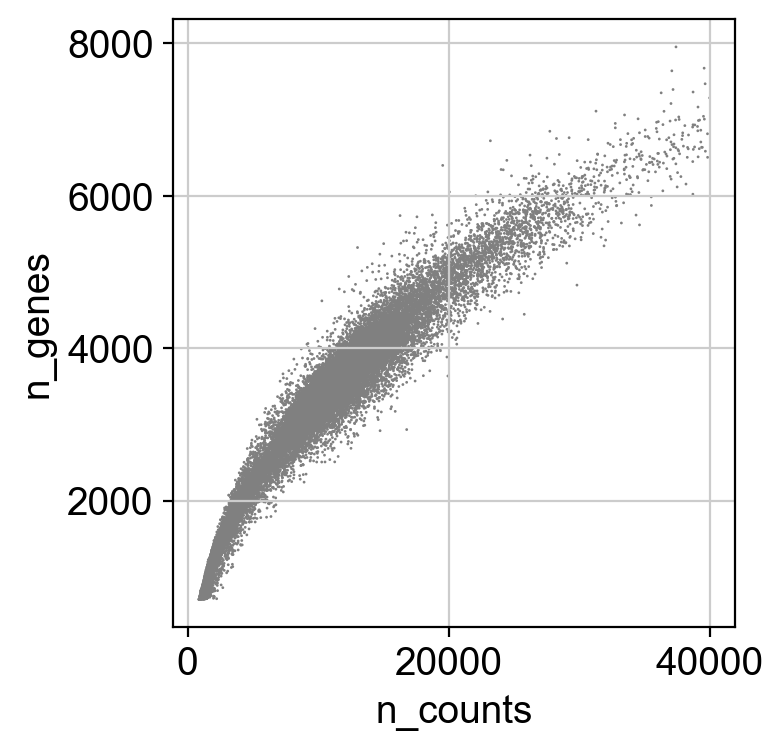

In [13]:
sc.pl.violin(P28_dl, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(P28_dl, x='n_counts', y='percent_mito')
sc.pl.scatter(P28_dl, x='n_counts', y='n_genes')

## Doublet detection

Using the filtering info obtained by joint analysis, the object for which has now been deleted.

In [28]:
del P28_dl

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 8.5%
Estimated detectable doublet fraction = 68.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 12.5%
Elapsed time: 13.3 seconds


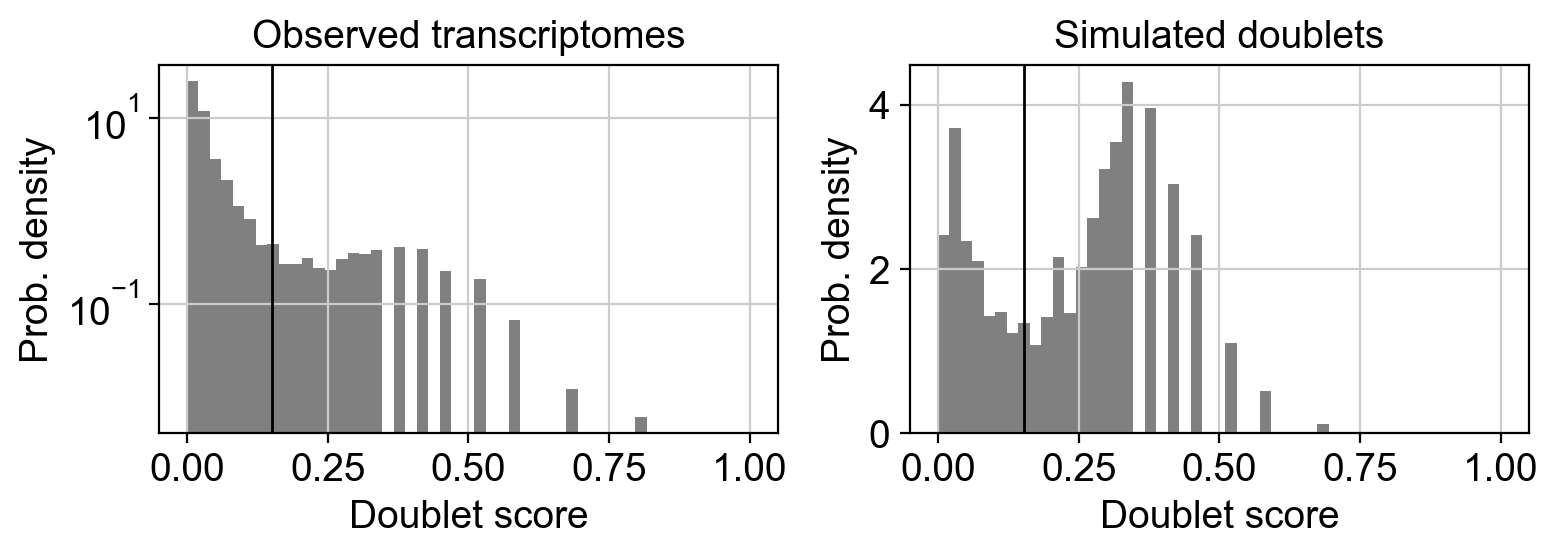

Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 8.2%
Estimated detectable doublet fraction = 66.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 12.3%
Elapsed time: 11.0 seconds


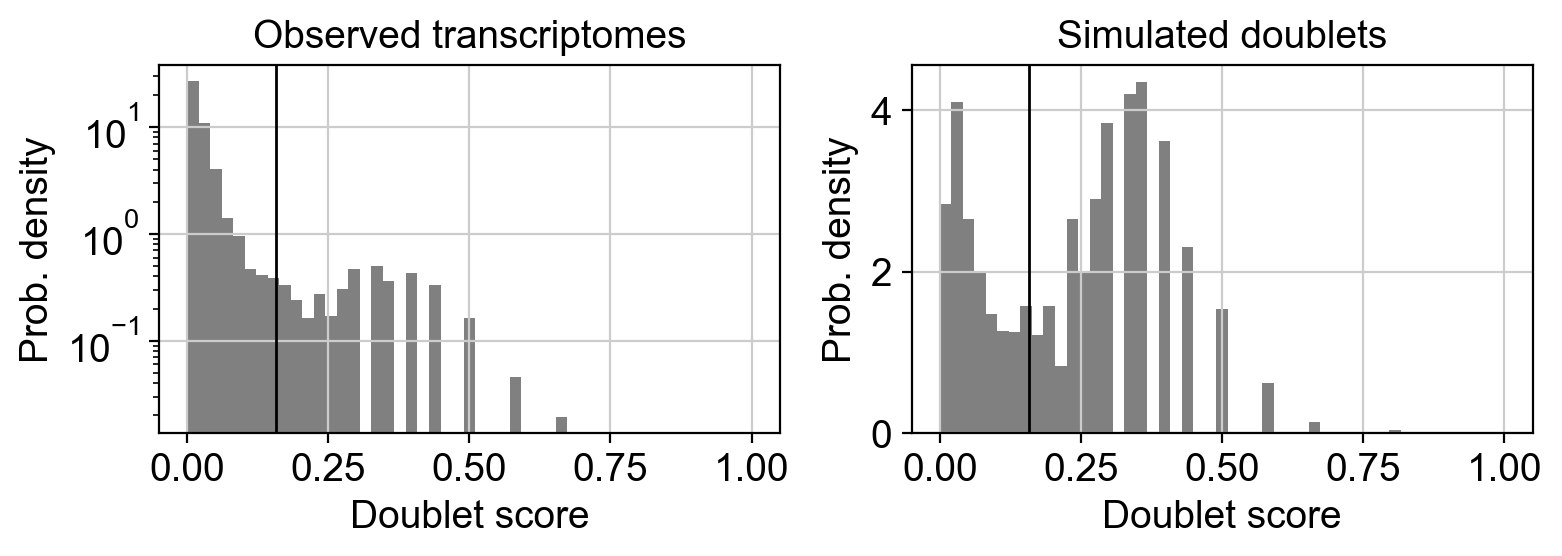

Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.17
Detected doublet rate = 6.7%
Estimated detectable doublet fraction = 60.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 11.1%
Elapsed time: 10.9 seconds


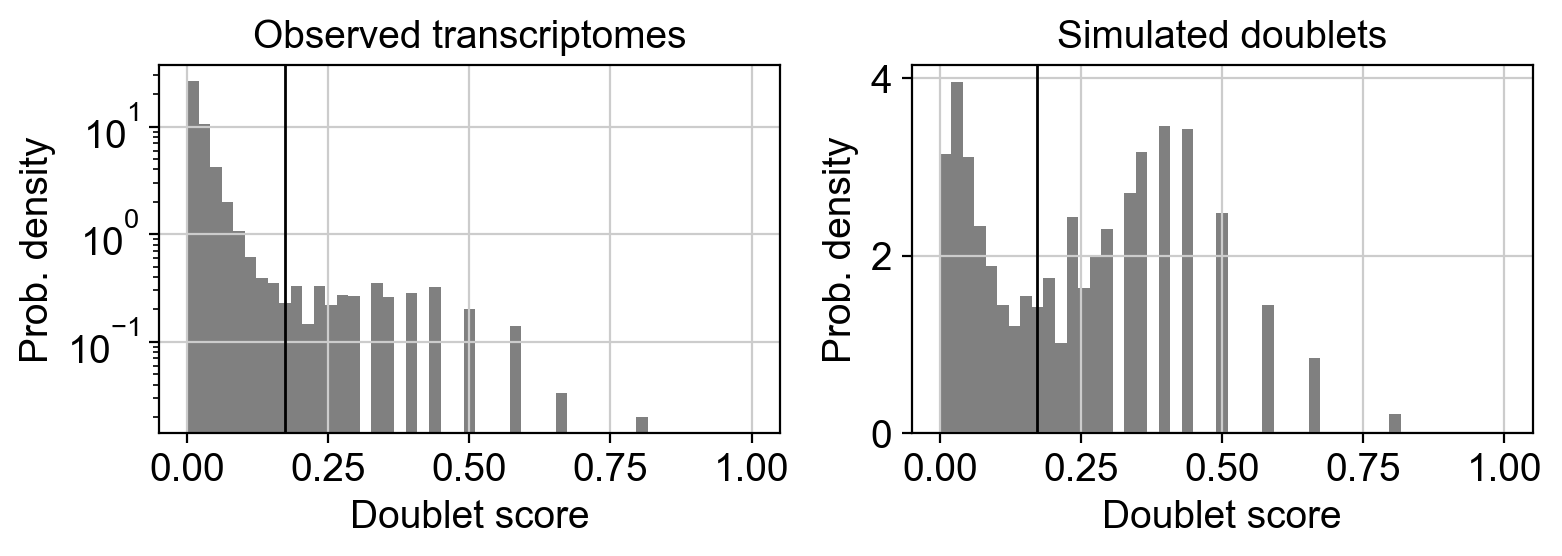

Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.18
Detected doublet rate = 7.0%
Estimated detectable doublet fraction = 60.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 11.6%
Elapsed time: 10.5 seconds


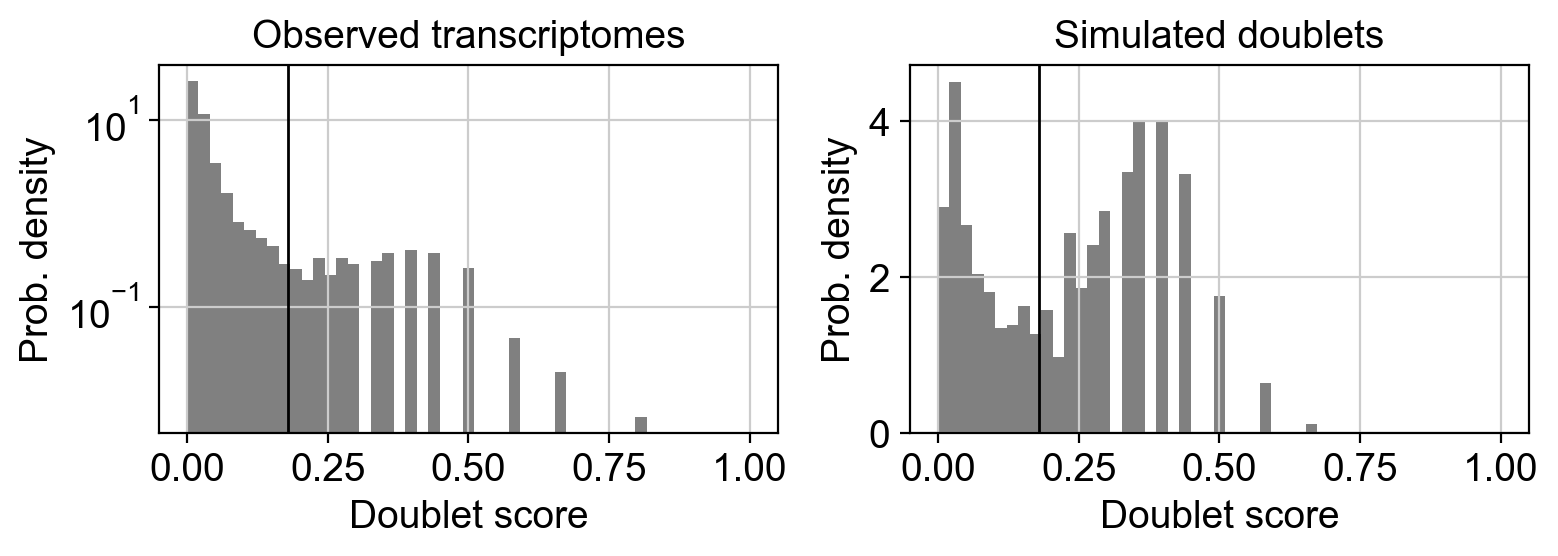

Trying to set attribute `.obs` of view, copying.


In [29]:
samples = [oneA, oneB, twoA, twoB]
for i in range(len(samples)):
    sc.pp.filter_cells(samples[i], min_genes=700) #cell must have 700 non-zero-count features to stay
    sc.pp.filter_genes(samples[i], min_cells=8) #gene must be in 8 cells to stay

    mito_genes = samples[i].var_names.str.startswith('mt-') #boolean array denoting if a gene is mito

    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

    # add each cell's fraction mito accounts as an obs annotation
    samples[i].obs['percent_mito'] = np.sum(samples[i][:, mito_genes].X, axis=1).A1 / np.sum(samples[i].X, axis=1).A1

    # add the total counts per cell as observations-annotation to samples[i]
    samples[i].obs['n_counts'] = samples[i].X.sum(axis=1).A1

    samples[i] = samples[i][samples[i].obs.percent_mito < 0.01, :]
    samples[i] = samples[i][samples[i].obs['n_genes'] < 8000, :]
    samples[i] = samples[i][samples[i].obs['n_counts'] < 40000, :]
    

    counts_matrix = samples[i].X

    scrub = crub.Scrublet(counts_matrix, expected_doublet_rate=0.06)

    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=8, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=40)

    scrub.plot_histogram()
    plt.show()
    samples[i].obs['Doublet'] = scrub.predicted_doublets_
    samples[i].obs['Doublet Score'] = scrub.doublet_scores_obs_
    
P28_dl = samples[0].concatenate(samples[1], samples[2], samples[3], batch_categories=['P28_dl_1a', 'P28_dl_1b', 'P28_dl_2a', 'P28_dl_2b'])

In [8]:
#with filtering lines commented out above for cell IDs for sarah
#P28_dl.write_h5ad('P28_dl_raw_unfiltered.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


In [18]:
P28_dl[P28_dl.obs.Doublet==True,:].shape[0]*100/P28_dl.shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


7.630322323915639

In [19]:
P28_dl[P28_dl.obs.Doublet==True,:].shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


2301

(array([2.6314e+04, 1.5370e+03, 6.4800e+02, 5.8600e+02, 6.2600e+02,
        2.5700e+02, 1.2400e+02, 4.6000e+01, 1.3000e+01, 5.0000e+00]),
 array([0.00100418, 0.08217867, 0.16335315, 0.24452763, 0.32570211,
        0.40687659, 0.48805108, 0.56922556, 0.65040004, 0.73157452,
        0.812749  ]),
 <BarContainer object of 10 artists>)

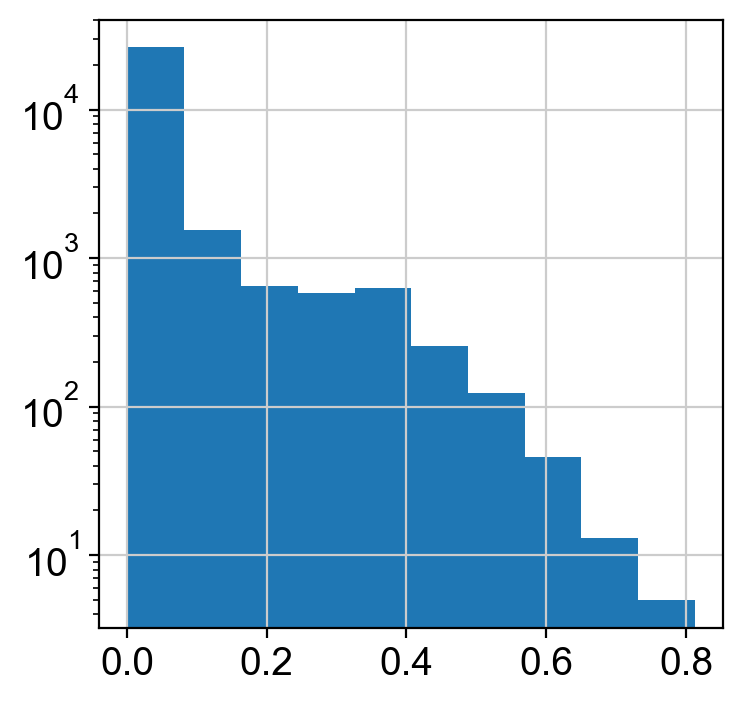

In [20]:
plt.hist(P28_dl.obs['Doublet Score'], log='y')

## Pre-processing and clustering workflow

In [30]:
sc.pp.normalize_per_cell(P28_dl, counts_per_cell_after=1e4)
sc.pp.log1p(P28_dl)

normalizing by total count per cell


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [31]:
P28_dl.raw = P28_dl #store pre-scale counts

In [32]:
sc.pp.highly_variable_genes(P28_dl, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P28_dl, max_value=10) #scale

sc.tl.pca(P28_dl, svd_solver='arpack') #run PCA

sc.pp.neighbors(P28_dl, n_neighbors=25, n_pcs=40) #choose 25 standard for now
#bbknn(P28_dl, batch_key='batch',neighbors_within_batch =6 ) #6*4 ~ 25, which is consistent for other ages

sc.tl.leiden(P28_dl)
sc.tl.umap(P28_dl)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


#first run 
#doublets and/or disperse expression of markers
P28_dl = P28_dl[P28_dl.obs['leiden']!='15',:]#dub
P28_dl = P28_dl[P28_dl.obs['leiden']!='20',:]#dub
P28_dl = P28_dl[P28_dl.obs['leiden']!='21',:]#dub
P28_dl = P28_dl[P28_dl.obs['leiden']!='22',:]#dub
P28_dl = P28_dl[P28_dl.obs['leiden']!='24',:]#diffuse gluta markers
P28_dl = P28_dl[P28_dl.obs['leiden']!='28',:]#diffuse gluta markers

#second run after above clean-up
P28_dl = P28_dl[P28_dl.obs['leiden']!='19',:] #dub

In [44]:
sc.pp.neighbors(P28_dl, n_neighbors=25, n_pcs=40) #choose 25 standard for now
#bbknn(P28_dl, batch_key='batch',neighbors_within_batch =6 ) #6*4 ~ 25, which is consistent for other ages

sc.tl.leiden(P28_dl)
sc.tl.umap(P28_dl)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


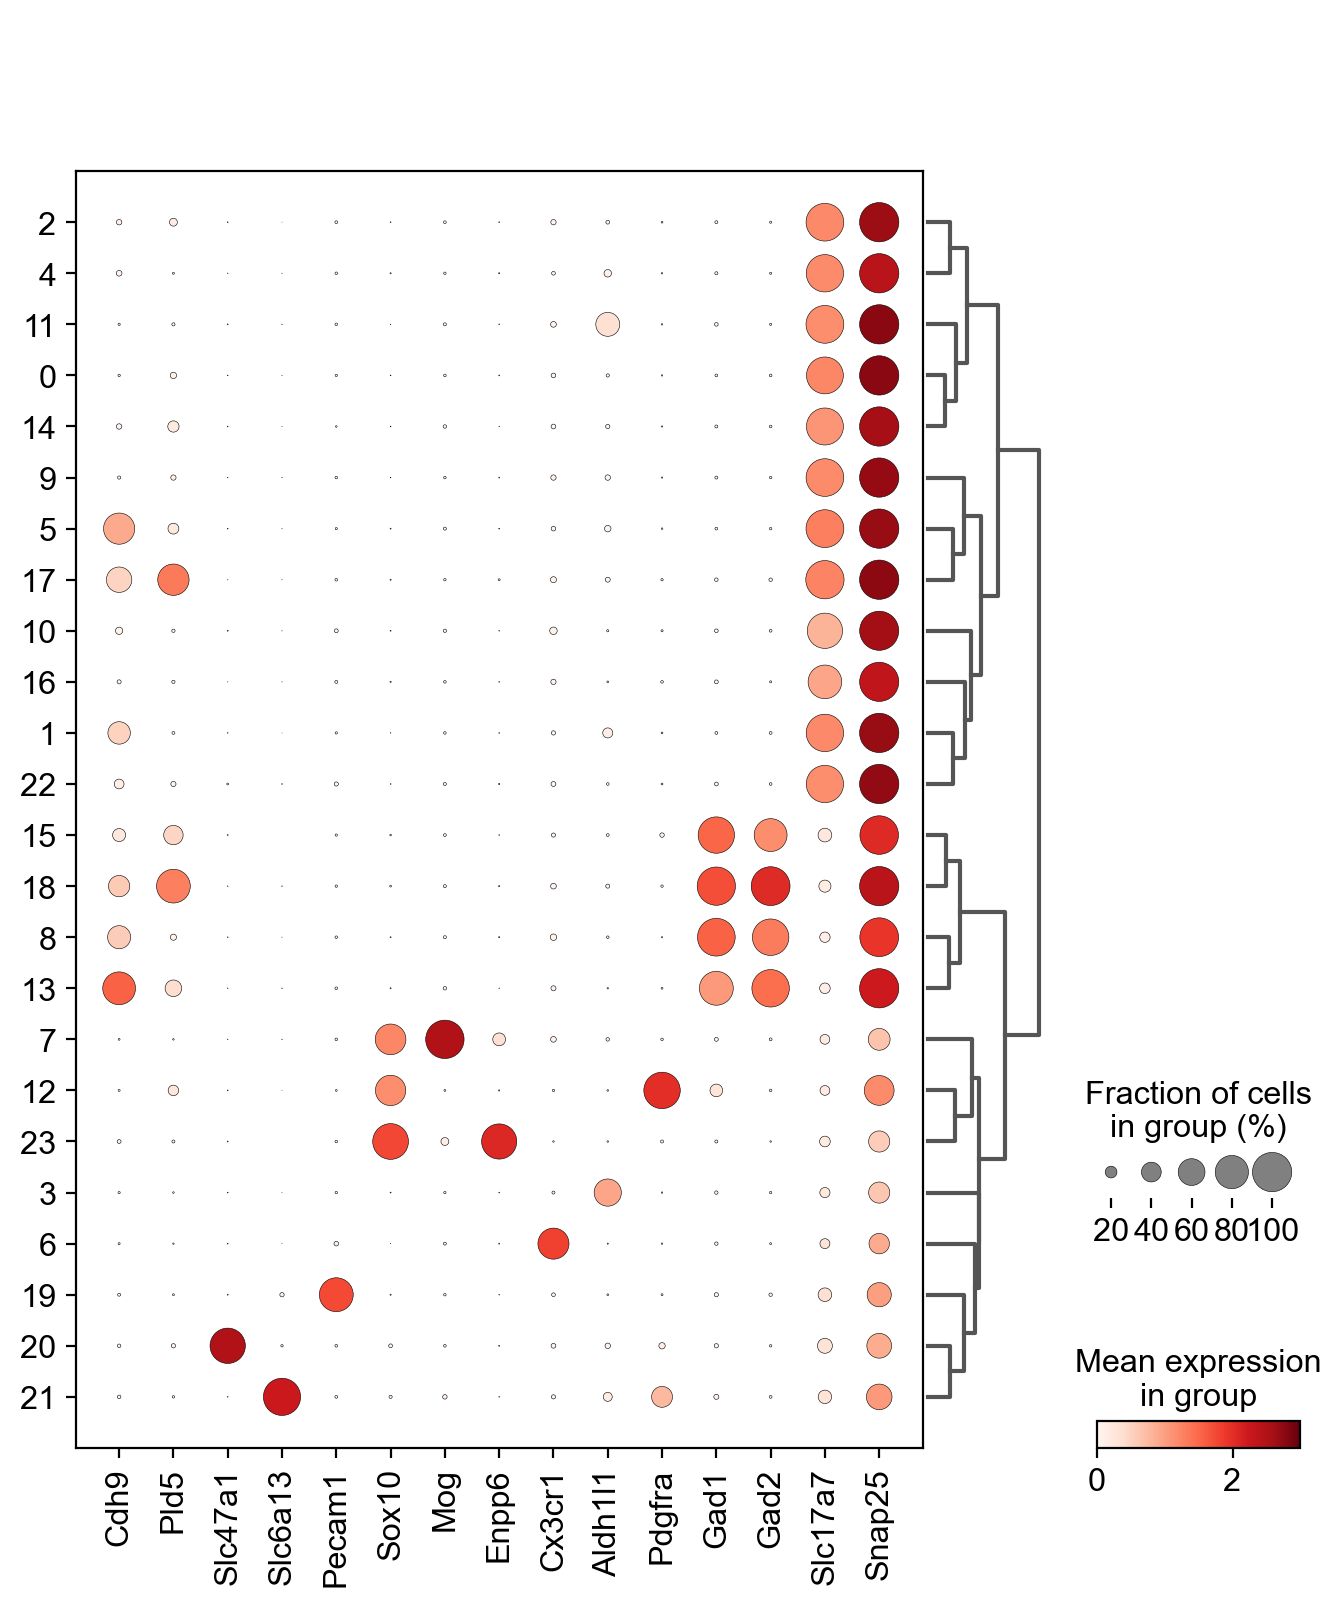

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

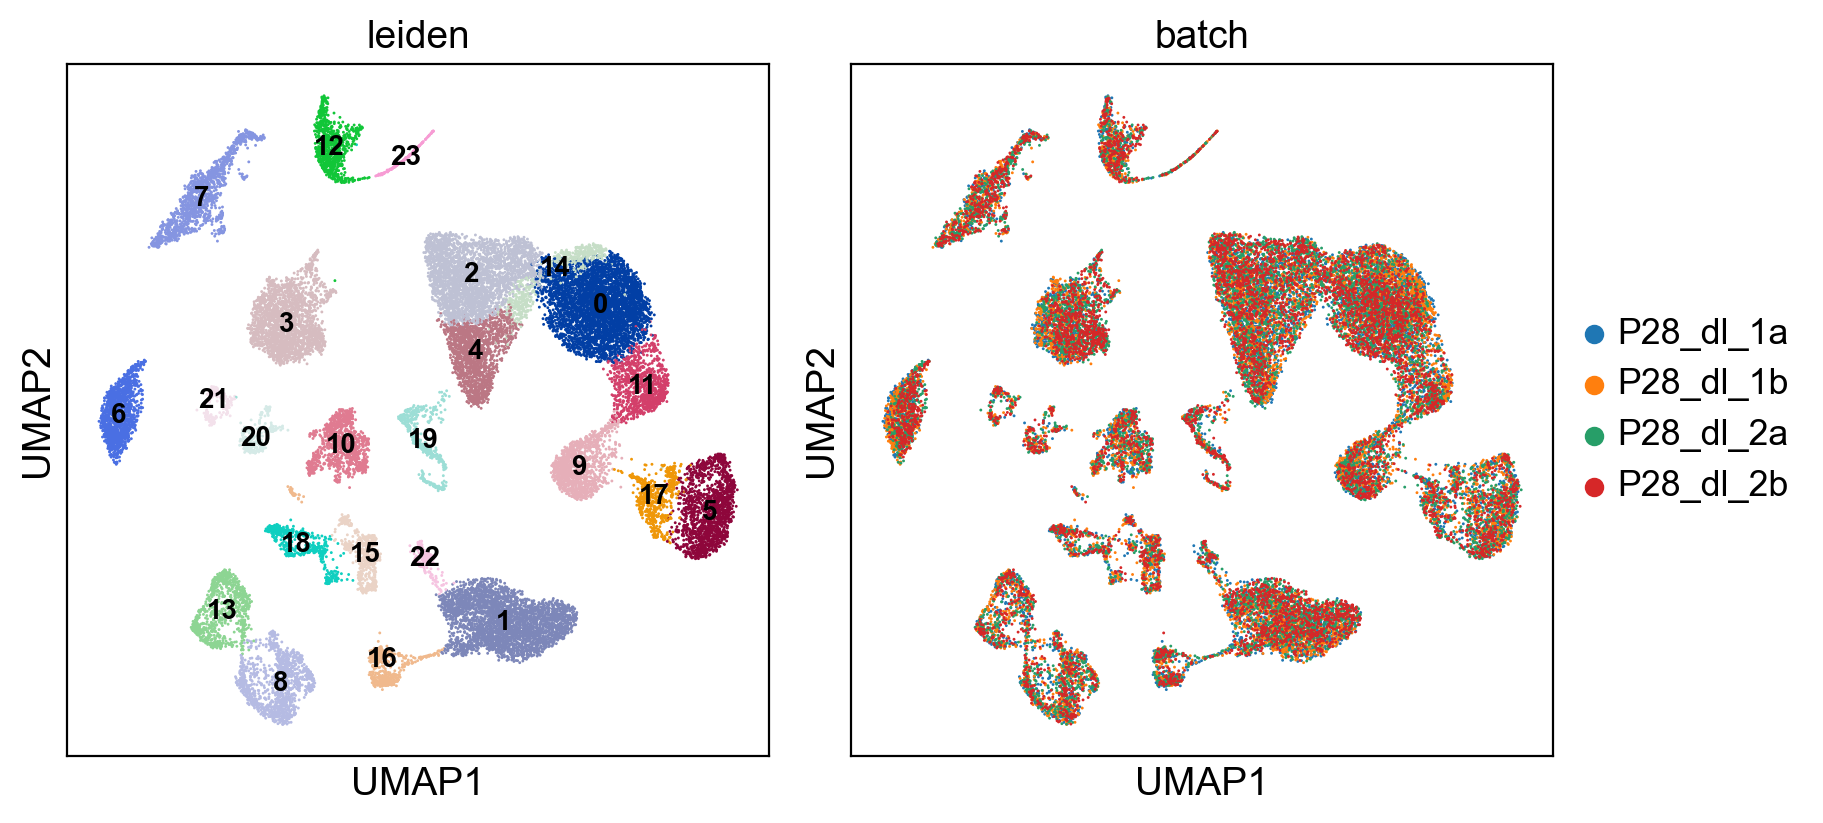

In [45]:
#w/o bbknn
sc.tl.dendrogram(P28_dl, groupby='leiden')
leiden_markers = ['Cdh9', 'Pld5', 
                  'Slc47a1', 'Slc6a13', 
                'Pecam1', 'Sox10', 'Mog',
                   'Enpp6', 'Cx3cr1',  'Aldh1l1', 'Pdgfra', 'Gad1', 'Gad2', 'Slc17a7','Snap25']

sc.pl.dotplot(P28_dl, leiden_markers, groupby='leiden', dendrogram=True, vmax=3)


fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)

sc.pl.umap(P28_dl, color=['leiden'], legend_fontsize='10', legend_loc='on data', ax=axs[0], show=False)
sc.pl.umap(P28_dl, color=['batch'], ax=axs[1], show=False)

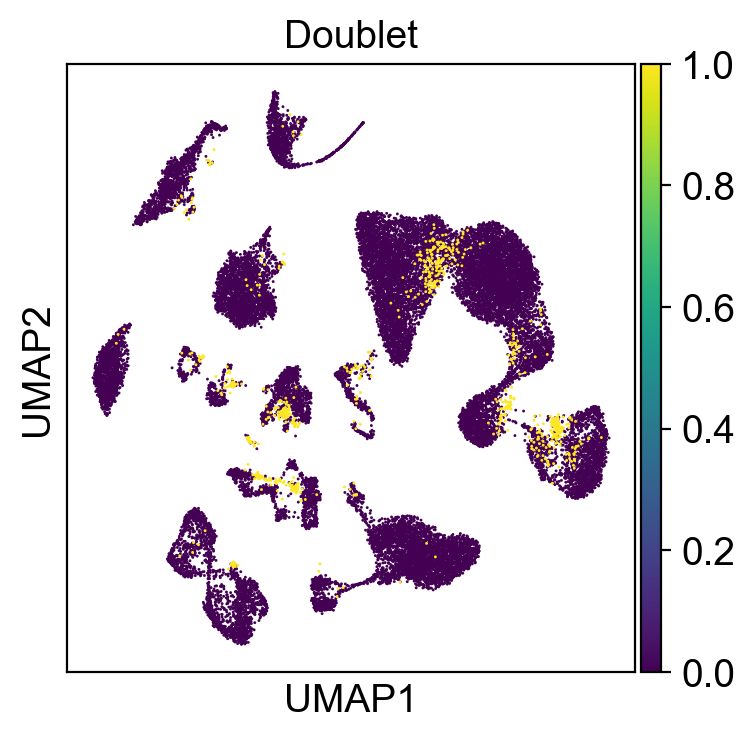

In [46]:
sc.pl.umap(P28_dl, color=['Doublet'])

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


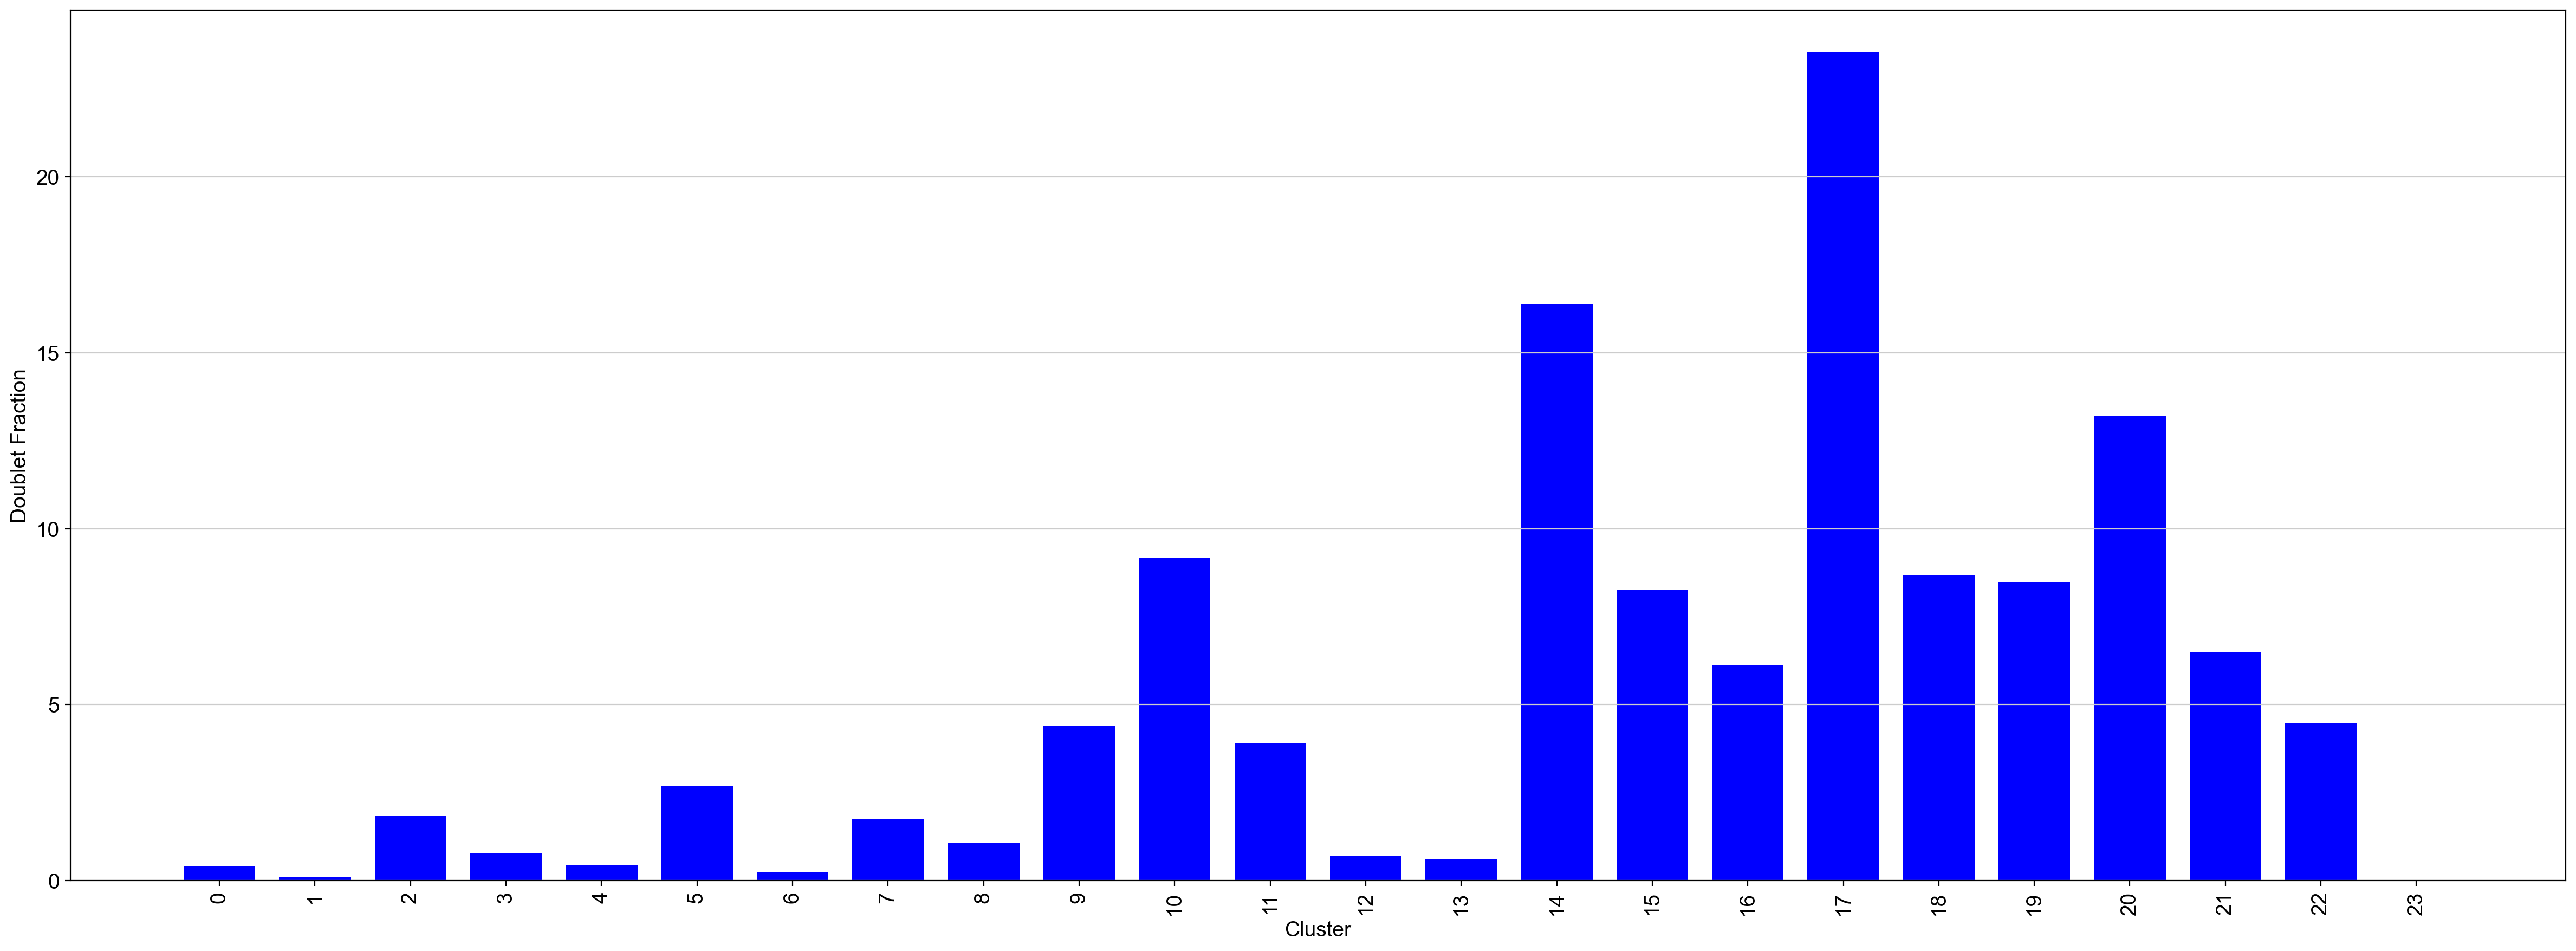

In [47]:
doublet_perc = []
x_pos = list(P28_dl.obs.leiden.values.categories)
for i in x_pos:
    current_clust = P28_dl[P28_dl.obs.leiden==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()

Text(0, 0.5, 'Percentage of cells')

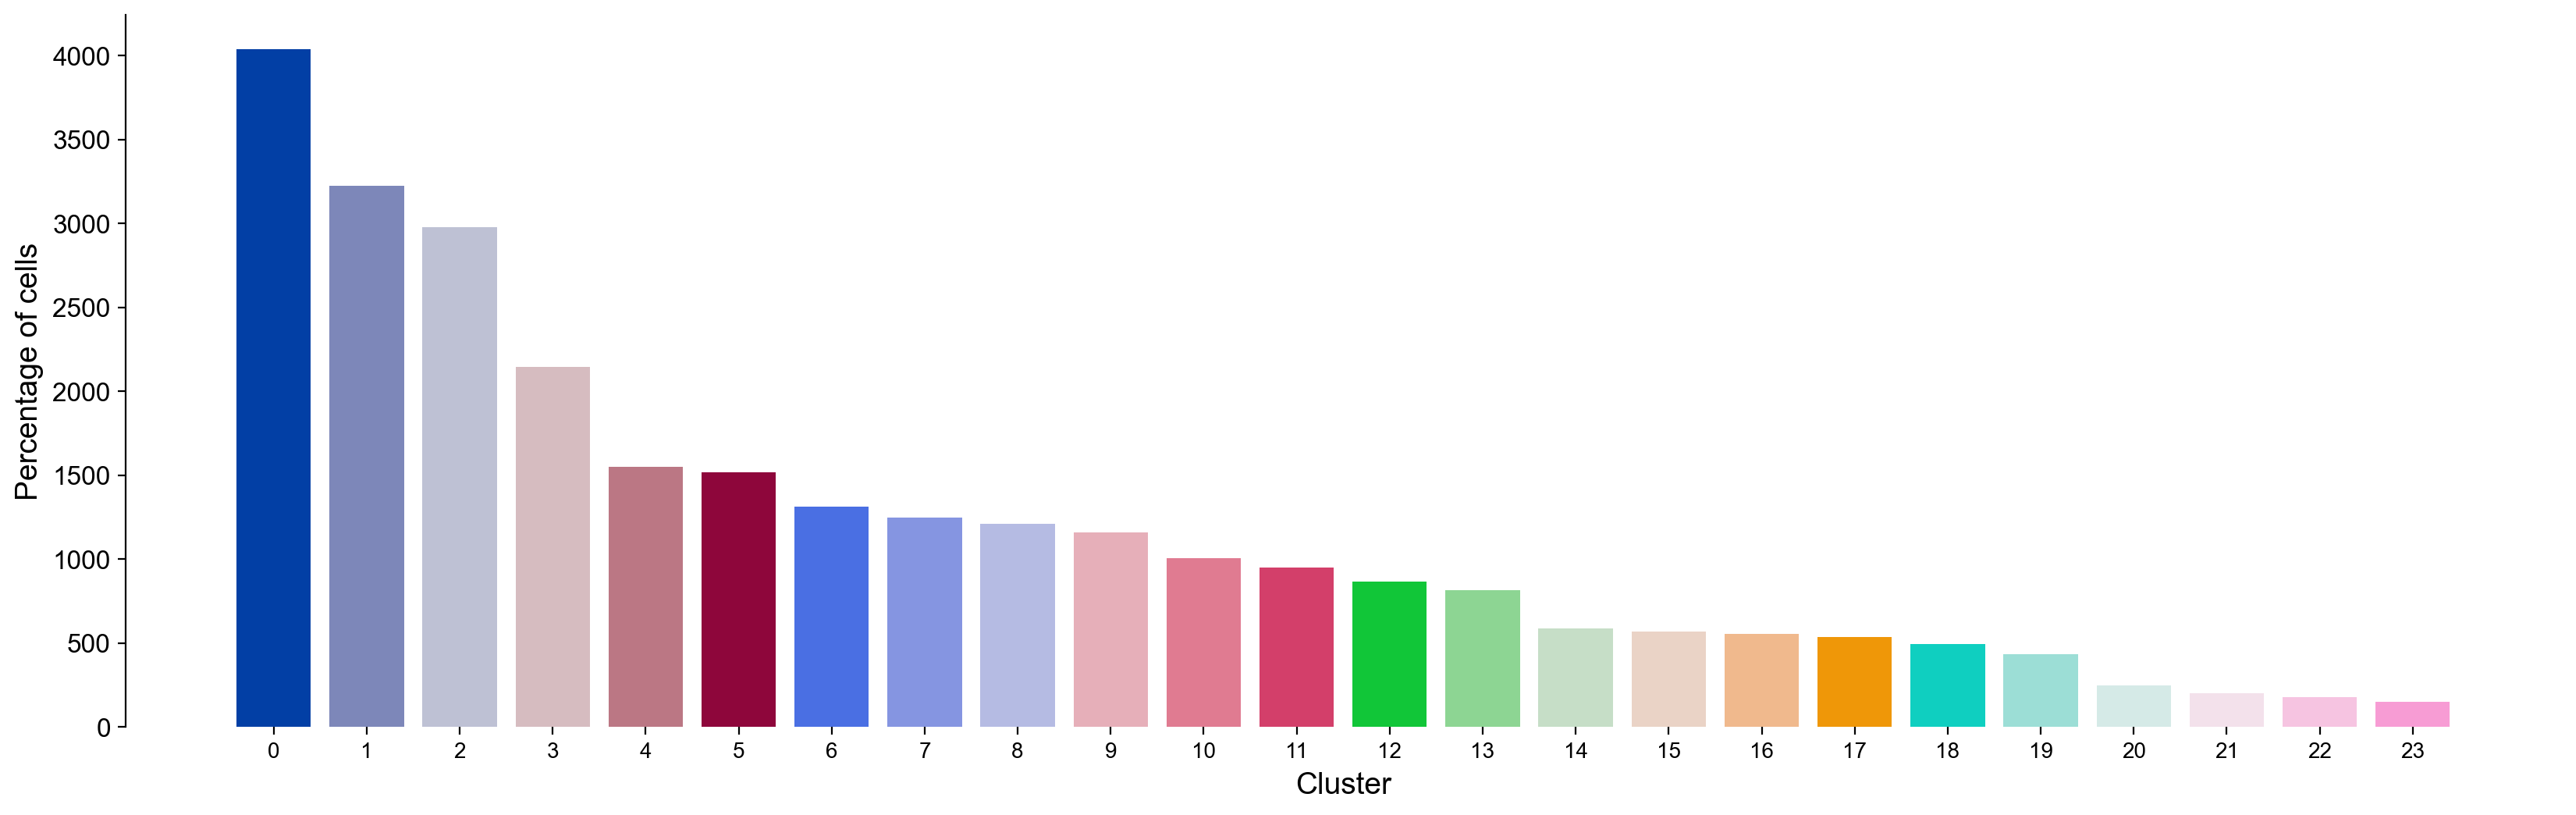

In [48]:
#code
x_pos = list(P28_dl.obs.leiden.values.categories)

total_cells = P28_dl.shape[0]
cell_fraction = []
cell_count = []

for i in x_pos:
    #cell_fraction.append(P28_dl[P28_dl.obs.leiden==i, :].shape[0]*100/total_cells)
    cell_fraction.append(P28_dl[P28_dl.obs.leiden==i, :].shape[0])
    cell_count.append(P28_dl[P28_dl.obs.leiden==i, :].shape[0])



fig, ax = plt.subplots(figsize=(20,6))

right_side = ax.spines["right"]
top = ax.spines["top"]
bottom = ax.spines["bottom"]

right_side.set_visible(False)
top.set_visible(False)
bottom.set_visible(False)


plt.bar(x_pos, cell_fraction, color = P28_dl.uns['leiden_colors'])
plt.grid(False)
plt.xticks(rotation='0', fontsize='10')
plt.yticks(fontsize ='12')

plt.xlabel('Cluster', rotation='0')
plt.ylabel('Percentage of cells')

#axs.set_yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000])


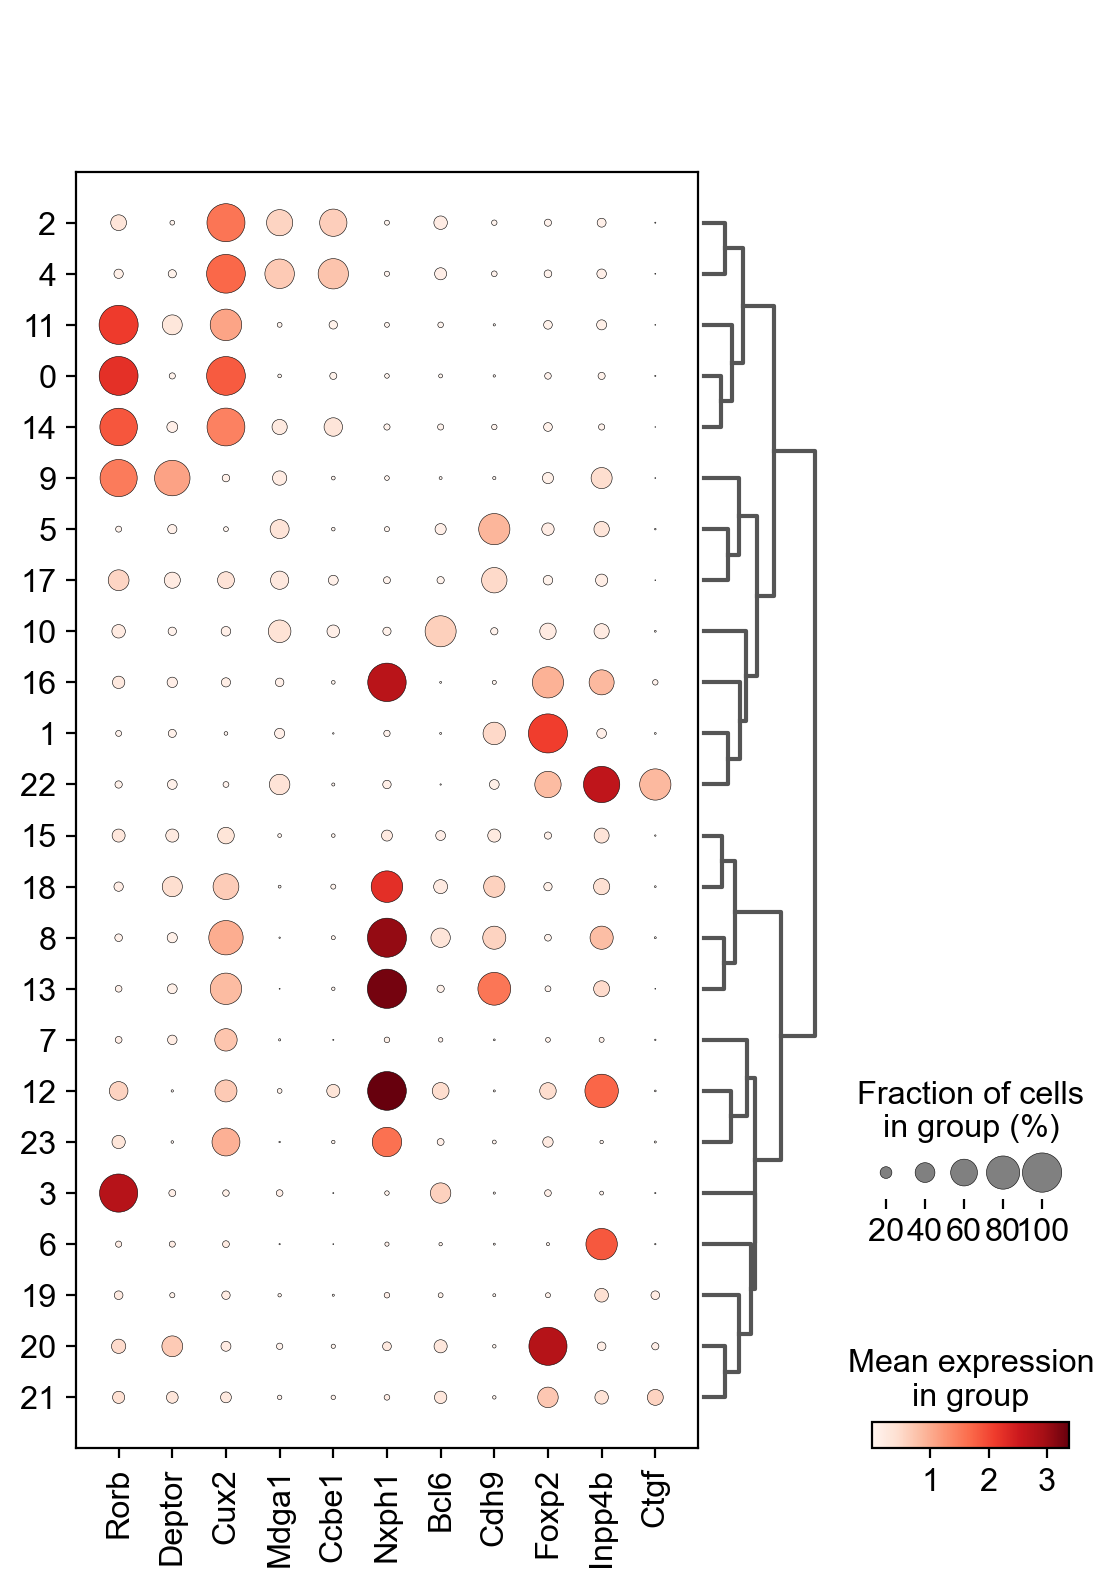

In [49]:
sc.pl.dotplot(P28_dl, ['Rorb', 'Deptor', 'Cux2', 'Mdga1', 'Ccbe1', 'Nxph1', 'Bcl6',
                'Cdh9', 'Foxp2', 'Inpp4b', 'Ctgf'], groupby='leiden', dendrogram=True)

In [50]:
#amount of gaba cells aligns well with NR
P28_dl[P28_dl.obs.leiden=='8',:].shape[0] + P28_dl[P28_dl.obs.leiden=='13',:].shape[0] + P28_dl[P28_dl.obs.leiden=='15',:].shape[0] + P28_dl[P28_dl.obs.leiden=='18',:].shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


3089

## Remove doublets and export 3 objs


In [51]:
P28_dl.shape

(27980, 20575)

In [56]:
P28_dl_dub = P28_dl[P28_dl.obs.Doublet==False,:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [57]:
P28_dl_dub.shape

(27175, 20575)

In [73]:
P28_dl_dub.obs['sample'] = P28_dl_dub.obs['batch']

Trying to set attribute `.obs` of view, copying.


In [74]:
P28_dl_dub.raw.X.A

array([[3.1402893, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.1207736, 0.       , 0.       , ..., 1.8937589, 0.       ,
        0.       ],
       [2.4728298, 0.       , 0.       , ..., 0.6070843, 0.       ,
        0.       ],
       ...,
       [3.078152 , 0.6864158, 0.       , ..., 0.6864158, 0.       ,
        0.       ],
       [1.0566441, 0.       , 0.       , ..., 2.3402183, 0.       ,
        0.       ],
       [0.9851203, 0.       , 0.       , ..., 1.7974768, 0.       ,
        0.       ]], dtype=float32)

### GABAergic

In [76]:
P28_gaba = P28_dl_dub[P28_dl_dub.obs.leiden=='8',:].concatenate(P28_dl_dub[P28_dl_dub.obs.leiden=='13',:],
                                                                 P28_dl_dub[P28_dl_dub.obs.leiden=='15',:],
                                                               P28_dl_dub[P28_dl_dub.obs.leiden=='18',:])

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [77]:
P28_gaba.raw.X.A

array([[3.1402893 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.4728298 , 0.        , 0.        , ..., 0.6070843 , 0.        ,
        0.        ],
       [2.8399467 , 0.        , 0.        , ..., 1.9256997 , 0.        ,
        0.        ],
       ...,
       [2.389508  , 0.64224255, 0.        , ..., 1.7054193 , 0.        ,
        0.        ],
       [2.8123772 , 0.8346993 , 0.        , ..., 2.1775575 , 0.        ,
        0.        ],
       [2.181034  , 0.        , 0.        , ..., 1.6797369 , 0.        ,
        0.        ]], dtype=float32)

In [78]:
pd.Categorical(P28_gaba.obs.leiden)

['8', '8', '8', '8', '8', ..., '18', '18', '18', '18', '18']
Length: 2981
Categories (4, object): ['13', '15', '18', '8']

In [79]:
P28_gaba.write_h5ad(export_path + 'P28_dl_gaba.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


### Glutamatergic

In [80]:
P28_glut = P28_dl_dub[P28_dl_dub.obs.leiden=='2',:].concatenate(P28_dl_dub[P28_dl_dub.obs.leiden=='4',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='11',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='0',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='14',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='9',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='5',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='17',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='10',:],
                                                               P28_dl_dub[P28_dl_dub.obs.leiden=='16',:], 
                                                               P28_dl_dub[P28_dl_dub.obs.leiden=='1',:], 
                                                               P28_dl_dub[P28_dl_dub.obs.leiden=='22',:])

In [81]:
P28_glut.raw.X.A

array([[2.1207736 , 0.        , 0.        , ..., 1.8937589 , 0.        ,
        0.        ],
       [1.8939027 , 0.        , 0.        , ..., 2.0508237 , 0.        ,
        0.        ],
       [2.4813757 , 0.        , 0.        , ..., 1.8685433 , 0.        ,
        0.        ],
       ...,
       [2.9851868 , 0.        , 0.        , ..., 1.8015282 , 0.        ,
        0.        ],
       [3.0759492 , 0.        , 0.        , ..., 1.0287011 , 0.        ,
        0.        ],
       [3.2862406 , 0.43677327, 0.        , ..., 1.9494406 , 0.        ,
        0.        ]], dtype=float32)

In [82]:
P28_glut.obs

,n_genes,percent_mito,n_counts,Doublet,Doublet Score,batch,leiden,sample
AAACCCACAAACCATC-1-P28_dl_1a-0,4597,0.000056,17717.0,False,0.046761,0,2,P28_dl_1a
AAACGAAAGGGTTAGC-1-P28_dl_1a-0,3018,0.000000,8857.0,False,0.119914,0,2,P28_dl_1a
AAACGAATCCGACGGT-1-P28_dl_1a-0,2903,0.000219,9126.0,False,0.016393,0,2,P28_dl_1a
AAACGCTTCCAAGAGG-1-P28_dl_1a-0,3861,0.000079,12616.0,False,0.048147,0,2,P28_dl_1a
AAAGGATTCGTAACAC-1-P28_dl_1a-0,3610,0.000081,12401.0,False,0.069532,0,2,P28_dl_1a
...,...,...,...,...,...,...,...,...
TCATGCCAGAGATCGC-1-P28_dl_2b-11,4086,0.001261,15063.0,False,0.097022,11,22,P28_dl_2b
TCGACCTAGGCGAACT-1-P28_dl_2b-11,3938,0.000071,14093.0,False,0.012873,11,22,P28_dl_2b
TGATGGTGTGAATAAC-1-P28_dl_2b-11,4110,0.000506,13837.0,False,0.067692,11,22,P28_dl_2b
TGTGTGAGTTCAATCG-1-P28_dl_2b-11,3230,0.000539,11127.0,False,0.086572,11,22,P28_dl_2b


In [83]:
P28_glut.write_h5ad(export_path + 'P28_dl_glut.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


### Non-neurons

In [84]:
P28_non = P28_dl_dub[P28_dl_dub.obs.leiden=='7',:].concatenate(P28_dl_dub[P28_dl_dub.obs.leiden=='12',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='23',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='3',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='6',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='19',:],
                                                                P28_dl_dub[P28_dl_dub.obs.leiden=='20',:],
                                                              P28_dl_dub[P28_dl_dub.obs.leiden=='21',:])

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [85]:
P28_non.write_h5ad(export_path + 'P28_dl_non.h5ad')

... storing 'leiden' as categorical


In [86]:
#all cells exported
P28_non.shape[0] + P28_gaba.shape[0] + P28_glut.shape[0] == P28_dl_dub.shape[0]

True